In [1]:
import numpy as _np
import torch as _torch
_torch.manual_seed(0)

from math import log as _log
import math

from torch import nn as _nn
from torch.optim import Adam as _Adam
from torch.nn.functional import softmax as _softmax
from torch.utils.data import DataLoader as _DataLoader
from torch.utils.data.dataset import TensorDataset as _TensorDataset

from DRBin.calculate_graph import *
from DRBin.eval import *
import DRBin
import DRBin.utils
from DRBin.my_cluster import *

In [200]:
def numpy_inplace_maskarray(array, mask):
    """In-place masking of a Numpy array, i.e. if `mask` is a boolean mask of same
    length as `array`, then array[mask] == numpy_inplace_maskarray(array, mask),
    but does not allocate a new array.
    """

    if len(mask) != len(array):
        raise ValueError('Lengths of array and mask must match')
    elif len(array.shape) != 2:
        raise ValueError('Can only take a 2 dimensional-array.')

    uints = _np.frombuffer(mask, dtype=_np.uint8)
    index = _overwrite_matrix(array, uints)
    array.resize((index, array.shape[1]), refcheck=False)
    return array

In [201]:
def zscore(array, axis=None, inplace=False):
    """Calculates zscore for an array. A cheap copy of scipy.stats.zscore.
    Inputs:
        array: Numpy array to be normalized
        axis: Axis to operate across [None = entrie array]
        inplace: Do not create new array, change input array [False]
    Output:
        If inplace is True: None
        else: New normalized Numpy-array"""

    if axis is not None and axis >= array.ndim:
        raise _np.AxisError('array only has {} axes'.format(array.ndim))

    if inplace and not _np.issubdtype(array.dtype, _np.floating):
        raise TypeError('Cannot convert a non-float array to zscores')

    mean = array.mean(axis=axis)
    std = array.std(axis=axis)

    if axis is None:
        if std == 0:
            std = 1 # prevent divide by zero

    else:
        std[std == 0.0] = 1 # prevent divide by zero
        shape = tuple(dim if ax != axis else 1 for ax, dim in enumerate(array.shape))
        mean.shape, std.shape = shape, shape

    if inplace:
        array -= mean
        array /= std
        return None
    else:
        return (array - mean) / std

In [202]:
if _torch.__version__ < '0.4':
    raise ImportError('PyTorch version must be 0.4 or newer')

def make_dataloader(rpkm, tnf, batchsize=256, destroy=False, cuda=True):
    """Create a DataLoader and a contig mask from RPKM and TNF.
    The dataloader is an object feeding minibatches of contigs to the VAE.
    The data are normalized versions of the input datasets, with zero-contigs,
    i.e. contigs where a row in either TNF or RPKM are all zeros, removed.
    The mask is a boolean mask designating which contigs have been kept.
    Inputs:
        rpkm: RPKM matrix (N_contigs x N_samples)
        tnf: TNF matrix (N_contigs x N_TNF)
        batchsize: Starting size of minibatches for dataloader
        destroy: Mutate rpkm and tnf array in-place instead of making a copy.
        cuda: Pagelock memory of dataloader (use when using GPU acceleration)
    Outputs:
        DataLoader: An object feeding data to the VAE
        mask: A boolean mask of which contigs are kept
    """

    if not isinstance(rpkm, _np.ndarray) or not isinstance(tnf, _np.ndarray):
        raise ValueError('TNF and RPKM must be Numpy arrays')

    if batchsize < 1:
        raise ValueError('Minimum batchsize of 1, not {}'.format(batchsize))

    if len(rpkm) != len(tnf):
        raise ValueError('Lengths of RPKM and TNF must be the same')

    if not (rpkm.dtype == tnf.dtype == _np.float32):
        raise ValueError('TNF and RPKM must be Numpy arrays of dtype float32')

    mask = tnf.sum(axis=1) != 0

    # If multiple samples, also include nonzero depth as requirement for accept
    # of sequences
    if rpkm.shape[1] > 1:
        depthssum = rpkm.sum(axis=1)
        mask &= depthssum != 0
        depthssum = depthssum[mask]

    if mask.sum() < batchsize:
        raise ValueError('Fewer sequences left after filtering than the batch size.')

    if destroy:
        rpkm = numpy_inplace_maskarray(rpkm, mask)
        tnf = numpy_inplace_maskarray(tnf, mask)
    else:
        # The astype operation does not copy due to "copy=False", but the masking
        # operation does.
        rpkm = rpkm[mask].astype(_np.float32, copy=False)
        tnf = tnf[mask].astype(_np.float32, copy=False)

    # If multiple samples, normalize to sum to 1, else zscore normalize
    if rpkm.shape[1] > 1:
        rpkm /= depthssum.reshape((-1, 1))
    else:
        zscore(rpkm, axis=0, inplace=True)

    # Normalize arrays and create the Tensors (the tensors share the underlying memory)
    # of the Numpy arrays
    zscore(tnf, axis=0, inplace=True)
    depthstensor = _torch.from_numpy(rpkm)
    tnftensor = _torch.from_numpy(tnf)

    # Create dataloader
    n_workers = 4 if cuda else 1
    dataset = _TensorDataset(depthstensor, tnftensor)
    dataloader = _DataLoader(dataset=dataset, batch_size=batchsize, drop_last=True,
                             shuffle=True, num_workers=n_workers, pin_memory=cuda)

    return dataloader, mask

In [203]:
import torch
import numpy as np
import scipy.special
from numbers import Number


class IveFunction(torch.autograd.Function):
    @staticmethod
    def forward(self, v, z):

        assert isinstance(v, Number), "v must be a scalar"

        self.save_for_backward(z)
        self.v = v
        z_cpu = z.data.cpu().numpy()

        if np.isclose(v, 0):
            output = scipy.special.i0e(z_cpu, dtype=z_cpu.dtype)
        elif np.isclose(v, 1):
            output = scipy.special.i1e(z_cpu, dtype=z_cpu.dtype)
        else:  #  v > 0
            output = scipy.special.ive(v, z_cpu, dtype=z_cpu.dtype)
        #         else:
        #             print(v, type(v), np.isclose(v, 0))
        #             raise RuntimeError('v must be >= 0, it is {}'.format(v))

        return torch.Tensor(output).to(z.device)

    @staticmethod
    def backward(self, grad_output):
        z = self.saved_tensors[-1]
        return (
            None,
            grad_output * (ive(self.v - 1, z) - ive(self.v, z) * (self.v + z) / z),
        )


class Ive(torch.nn.Module):
    def __init__(self, v):
        super(Ive, self).__init__()
        self.v = v

    def forward(self, z):
        return ive(self.v, z)


ive = IveFunction.apply


##########
# The below provided approximations were provided in the
# respective source papers, to improve the stability of
# the Bessel fractions.
# I_(v/2)(k) / I_(v/2 - 1)(k)

# source: https://arxiv.org/pdf/1606.02008.pdf
def ive_fraction_approx(v, z):
    # I_(v/2)(k) / I_(v/2 - 1)(k) >= z / (v-1 + ((v+1)^2 + z^2)^0.5
    return z / (v - 1 + torch.pow(torch.pow(v + 1, 2) + torch.pow(z, 2), 0.5))


# source: https://arxiv.org/pdf/1902.02603.pdf
def ive_fraction_approx2(v, z, eps=1e-20):
    def delta_a(a):
        lamb = v + (a - 1.0) / 2.0
        return (v - 0.5) + lamb / (
            2 * torch.sqrt((torch.pow(lamb, 2) + torch.pow(z, 2)).clamp(eps))
        )

    delta_0 = delta_a(0.0)
    delta_2 = delta_a(2.0)
    B_0 = z / (
        delta_0 + torch.sqrt((torch.pow(delta_0, 2) + torch.pow(z, 2))).clamp(eps)
    )
    B_2 = z / (
        delta_2 + torch.sqrt((torch.pow(delta_2, 2) + torch.pow(z, 2))).clamp(eps)
    )

    return (B_0 + B_2) / 2.0

In [204]:
class HypersphericalUniform(_torch.distributions.Distribution):

    support = _torch.distributions.constraints.real
    has_rsample = False
    _mean_carrier_measure = 0

    @property
    def dim(self):
        return self._dim

    @property
    def device(self):
        return self._device

    @device.setter
    def device(self, val):
        self._device = val if isinstance(val, _torch.device) else _torch.device(val)

    def __init__(self, dim, validate_args={}, device="cuda"):
        super(HypersphericalUniform, self).__init__(
            _torch.Size([dim]), validate_args=validate_args
        )
        self._dim = dim
        self.device = device

    def sample(self, shape=_torch.Size()):
        output = (
            _torch.distributions.Normal(0, 1)
            .sample(
                (shape if isinstance(shape, _torch.Size) else _torch.Size([shape]))
                + _torch.Size([self._dim + 1])
            )
            .to(self.device)
        )

        return output / output.norm(dim=-1, keepdim=True)

    def entropy(self):
        return self.__log_surface_area()

    def log_prob(self, x):
        return -_torch.ones(x.shape[:-1], device=self.device) * self.__log_surface_area()

    def __log_surface_area(self):
        if torch.__version__ >= "1.0.0":
            lgamma = _torch.lgamma(_torch.tensor([(self._dim + 1) / 2]).to(self.device))
        else:
            lgamma = _torch.lgamma(
                _torch.Tensor([(self._dim + 1) / 2], device=self.device)
            )
        return math.log(2) + ((self._dim + 1) / 2) * math.log(math.pi) - lgamma


In [205]:
class VonMisesFisher(_torch.distributions.Distribution):

    arg_constraints = {
        "loc": _torch.distributions.constraints.real,
        "scale": _torch.distributions.constraints.positive,
    }
    support = _torch.distributions.constraints.real
    has_rsample = True
    _mean_carrier_measure = 0

    @property
    def mean(self):
        # option 1:
        return self.loc * (
            ive(self.__m / 2, self.scale) / ive(self.__m / 2 - 1, self.scale)
        )
        # option 2:
        # return self.loc * ive_fraction_approx(torch.tensor(self.__m / 2), self.scale)
        # options 3:
        # return self.loc * ive_fraction_approx2(torch.tensor(self.__m / 2), self.scale)

    @property
    def stddev(self):
        return self.scale

    def __init__(self, loc, scale, validate_args=None, k=1):
        self.dtype = loc.dtype
        self.loc = loc
        self.scale = scale
        self.device = loc.device
        self.__m = loc.shape[-1]
        self.__e1 = (_torch.Tensor([1.0] + [0] * (loc.shape[-1] - 1))).to(self.device)
        self.k = k

        super().__init__(self.loc.size(), validate_args=validate_args)

    def sample(self, shape=_torch.Size()):
        with torch.no_grad():
            return self.rsample(shape)

    def rsample(self, shape=_torch.Size()):
        shape = shape if isinstance(shape, _torch.Size) else _torch.Size([shape])

        w = (
            self.__sample_w3(shape=shape)
            if self.__m == 3
            else self.__sample_w_rej(shape=shape)
        )

        v = (
            _torch.distributions.Normal(0, 1)
            .sample(shape + _torch.Size(self.loc.shape))
            .to(self.device)
            .transpose(0, -1)[1:]
        ).transpose(0, -1)
        v = v / v.norm(dim=-1, keepdim=True)

        w_ = _torch.sqrt(_torch.clamp(1 - (w ** 2), 1e-10))
        x = _torch.cat((w, w_ * v), -1)
        z = self.__householder_rotation(x)

        return z.type(self.dtype)

    def __sample_w3(self, shape):
        shape = shape + _torch.Size(self.scale.shape)
        u = _torch.distributions.Uniform(0, 1).sample(shape).to(self.device)
        self.__w = (
            1
            + _torch.stack(
                [_torch.log(u), _torch.log(1 - u) - 2 * self.scale], dim=0
            ).logsumexp(0)
            / self.scale
        )
        return self.__w

    def __sample_w_rej(self, shape):
        c = _torch.sqrt((4 * (self.scale ** 2)) + (self.__m - 1) ** 2)
        b_true = (-2 * self.scale + c) / (self.__m - 1)

        # using Taylor approximation with a smooth swift from 10 < scale < 11
        # to avoid numerical errors for large scale
        b_app = (self.__m - 1) / (4 * self.scale)
        s = _torch.min(
            _torch.max(
                _torch.tensor([0.0], dtype=self.dtype, device=self.device),
                self.scale - 10,
            ),
            _torch.tensor([1.0], dtype=self.dtype, device=self.device),
        )
        b = b_app * s + b_true * (1 - s)

        a = (self.__m - 1 + 2 * self.scale + c) / 4
        d = (4 * a * b) / (1 + b) - (self.__m - 1) * math.log(self.__m - 1)

        self.__b, (self.__e, self.__w) = b, self.__while_loop(b, a, d, shape, k=self.k)
        return self.__w

    @staticmethod
    def first_nonzero(x, dim, invalid_val=-1):
        mask = x > 0
        idx = _torch.where(
            mask.any(dim=dim),
            mask.float().argmax(dim=1).squeeze(),
            _torch.tensor(invalid_val, device=x.device),
        )
        return idx

    def __while_loop(self, b, a, d, shape, k=20, eps=1e-20):
        #  matrix while loop: samples a matrix of [A, k] samples, to avoid looping all together
        b, a, d = [
            e.repeat(*shape, *([1] * len(self.scale.shape))).reshape(-1, 1)
            for e in (b, a, d)
        ]
        w, e, bool_mask = (
            _torch.zeros_like(b).to(self.device),
            _torch.zeros_like(b).to(self.device),
            (_torch.ones_like(b) == 1).to(self.device),
        )

        sample_shape = _torch.Size([b.shape[0], k])
        shape = shape + _torch.Size(self.scale.shape)

        while bool_mask.sum() != 0:
            con1 = _torch.tensor((self.__m - 1) / 2, dtype=_torch.float64)
            con2 = _torch.tensor((self.__m - 1) / 2, dtype=_torch.float64)
            e_ = (
                _torch.distributions.Beta(con1, con2)
                .sample(sample_shape)
                .to(self.device)
                .type(self.dtype)
            )

            u = (
                _torch.distributions.Uniform(0 + eps, 1 - eps)
                .sample(sample_shape)
                .to(self.device)
                .type(self.dtype)
            )

            w_ = (1 - (1 + b) * e_) / (1 - (1 - b) * e_)
            t = (2 * a * b) / (1 - (1 - b) * e_)

            accept = ((self.__m - 1.0) * t.log() - t + d) > _torch.log(u)
            accept_idx = self.first_nonzero(accept, dim=-1, invalid_val=-1).unsqueeze(1)
            accept_idx_clamped = accept_idx.clamp(0)
            # we use .abs(), in order to not get -1 index issues, the -1 is still used afterwards
            w_ = w_.gather(1, accept_idx_clamped.view(-1, 1))
            e_ = e_.gather(1, accept_idx_clamped.view(-1, 1))

            reject = accept_idx < 0
            accept = ~reject if _torch.__version__ >= "1.2.0" else 1 - reject

            w[bool_mask * accept] = w_[bool_mask * accept]
            e[bool_mask * accept] = e_[bool_mask * accept]

            bool_mask[bool_mask * accept] = reject[bool_mask * accept]

        return e.reshape(shape), w.reshape(shape)

    def __householder_rotation(self, x):
        u = self.__e1 - self.loc
        u = u / (u.norm(dim=-1, keepdim=True) + 1e-5)
        z = x - 2 * (x * u).sum(-1, keepdim=True) * u
        return z

    def entropy(self):
        # option 1:
        output = (
            -self.scale
            * ive(self.__m / 2, self.scale)
            / ive((self.__m / 2) - 1, self.scale)
        )
        # option 2:
        # output = - self.scale * ive_fraction_approx(torch.tensor(self.__m / 2), self.scale)
        # option 3:
        # output = - self.scale * ive_fraction_approx2(torch.tensor(self.__m / 2), self.scale)

        return output.view(*(output.shape[:-1])) + self._log_normalization()

    def log_prob(self, x):
        return self._log_unnormalized_prob(x) - self._log_normalization()

    def _log_unnormalized_prob(self, x):
        output = self.scale * (self.loc * x).sum(-1, keepdim=True)

        return output.view(*(output.shape[:-1]))

    def _log_normalization(self):
        output = -(
            (self.__m / 2 - 1) * _torch.log(self.scale)
            - (self.__m / 2) * math.log(2 * math.pi)
            - (self.scale + _torch.log(ive(self.__m / 2 - 1, self.scale)))
        )

        return output.view(*(output.shape[:-1]))

In [206]:
class VAE(_nn.Module):
    """Variational autoencoder, subclass of torch.nn.Module.
    Instantiate with:
        nsamples: Number of samples in abundance matrix
        nhiddens: List of n_neurons in the hidden layers [None=Auto]
        nlatent: Number of neurons in the latent layer [32]
        alpha: Approximate starting TNF/(CE+TNF) ratio in loss. [None = Auto]
        beta: Multiply KLD by the inverse of this value [200]
        dropout: Probability of dropout on forward pass [0.2]
        cuda: Use CUDA (GPU accelerated training) [False]
    vae.trainmodel(dataloader, nepochs batchsteps, lrate, logfile, modelfile)
        Trains the model, returning None
    vae.encode(self, data_loader):
        Encodes the data in the data loader and returns the encoded matrix.
    If alpha or dropout is None and there is only one sample, they are set to
    0.99 and 0.0, respectively
    """

    def __init__(self, nsamples, nhiddens=None, nlatent=32, alpha=None,
                 beta=200, dropout=0.2, cuda=False):
        if nlatent < 1:
            raise ValueError('Minimum 1 latent neuron, not {}'.format(latent))

        if nsamples < 1:
            raise ValueError('nsamples must be > 0, not {}'.format(nsamples))

        # If only 1 sample, we weigh alpha and nhiddens differently
        if alpha is None:
            alpha = 0.15 if nsamples > 1 else 0.50

        if nhiddens is None:
            nhiddens = [512, 512] if nsamples > 1 else [256, 256]

        if dropout is None:
            dropout = 0.2 if nsamples > 1 else 0.0

        if any(i < 1 for i in nhiddens):
            raise ValueError('Minimum 1 neuron per layer, not {}'.format(min(nhiddens)))

        if beta <= 0:
            raise ValueError('beta must be > 0, not {}'.format(beta))

        if not (0 < alpha < 1):
            raise ValueError('alpha must be 0 < alpha < 1, not {}'.format(alpha))

        if not (0 <= dropout < 1):
            raise ValueError('dropout must be 0 <= dropout < 1, not {}'.format(dropout))

        super(VAE, self).__init__()

        # Initialize simple attributes
        self.usecuda = cuda
        self.nsamples = nsamples
        self.ntnf = 136
        self.alpha = alpha
        self.beta = beta
        self.nhiddens = nhiddens
        self.nlatent = nlatent
        self.dropout = dropout

        # Initialize lists for holding hidden layers
        self.encoderlayers = _nn.ModuleList()
        self.encodernorms = _nn.ModuleList()
        self.decoderlayers = _nn.ModuleList()
        self.decodernorms = _nn.ModuleList()

        # Add all other hidden layers
        for nin, nout in zip([self.nsamples + self.ntnf] + self.nhiddens, self.nhiddens):
            self.encoderlayers.append(_nn.Linear(nin, nout))
            self.encodernorms.append(_nn.BatchNorm1d(nout))

        # Latent layers
        self.mu = _nn.Linear(self.nhiddens[-1], self.nlatent)
        self.logsigma = _nn.Linear(self.nhiddens[-1], 1)

        # Add first decoding layer
        for nin, nout in zip([self.nlatent] + self.nhiddens[::-1], self.nhiddens[::-1]):
            self.decoderlayers.append(_nn.Linear(nin, nout))
            self.decodernorms.append(_nn.BatchNorm1d(nout))

        # Reconstruction (output) layer
        self.outputlayer = _nn.Linear(self.nhiddens[0], self.nsamples + self.ntnf)

        # Activation functions
        self.relu = _nn.LeakyReLU()
        self.softplus = _nn.Softplus()
        self.dropoutlayer = _nn.Dropout(p=self.dropout)

        if cuda:
            self.cuda()

    def _encode(self, tensor):
        tensors = list()

        # Hidden layers
        for encoderlayer, encodernorm in zip(self.encoderlayers, self.encodernorms):
            tensor = encodernorm(self.dropoutlayer(self.relu(encoderlayer(tensor))))
            tensors.append(tensor)

        # Latent layers
        mu = self.mu(tensor)
        mu = mu / mu.norm(dim=-1, keepdim=True)

        # Note: This softplus constrains logsigma to positive. As reconstruction loss pushes
        # logsigma as low as possible, and KLD pushes it towards 0, the optimizer will
        # always push this to 0, meaning that the logsigma layer will be pushed towards
        # negative infinity. This creates a nasty numerical instability in VAMB. Luckily,
        # the gradient also disappears as it decreases towards negative infinity, avoiding
        # NaN poisoning in most cases. We tried to remove the softplus layer, but this
        # necessitates a new round of hyperparameter optimization, and there is no way in
        # hell I am going to do that at the moment of writing.
        # Also remove needless factor 2 in definition of latent in reparameterize function.
        logsigma = self.softplus(self.logsigma(tensor)) + 1

        return mu, logsigma

    # sample with gaussian noise
    def reparameterize(self, mu, logsigma):
#         epsilon = _torch.randn(mu.size(0), mu.size(1))

#         if self.usecuda:
#             epsilon = epsilon.cuda()

#         epsilon.requires_grad = True

#         # See comment above regarding softplus
#         latent = mu + epsilon * _torch.exp(logsigma/2)

        q_z = VonMisesFisher(mu, logsigma)
        p_z = HypersphericalUniform(self.nlatent - 1)
        
        latent = q_z.rsample()
        
        return latent, q_z, p_z

    def _decode(self, tensor):
        tensors = list()

        for decoderlayer, decodernorm in zip(self.decoderlayers, self.decodernorms):
            tensor = decodernorm(self.dropoutlayer(self.relu(decoderlayer(tensor))))
            tensors.append(tensor)

        reconstruction = self.outputlayer(tensor)

        # Decompose reconstruction to depths and tnf signal
        depths_out = reconstruction.narrow(1, 0, self.nsamples)
        tnf_out = reconstruction.narrow(1, self.nsamples, self.ntnf)

        # If multiple samples, apply softmax
        if self.nsamples > 1:
            depths_out = _softmax(depths_out, dim=1)

        return depths_out, tnf_out

    def forward(self, depths, tnf):
        tensor = _torch.cat((depths, tnf), 1)
        mu, logsigma = self._encode(tensor)
        latent, q_z, p_z = self.reparameterize(mu, logsigma)
        depths_out, tnf_out = self._decode(latent)

        return depths_out, tnf_out, mu, logsigma, q_z, p_z

    def calc_loss(self, depths_in, depths_out, tnf_in, tnf_out, q_z, p_z):
        # If multiple samples, use cross entropy, else use SSE for abundance
        if self.nsamples > 1:
            # Add 1e-9 to depths_out to avoid numerical instability.
            ce = - ((depths_out + 1e-9).log() * depths_in).sum(dim=1).mean()
            ce_weight = (1 - self.alpha) / _log(self.nsamples)
        else:
            ce = (depths_out - depths_in).pow(2).sum(dim=1).mean()
            ce_weight = 1 - self.alpha

        sse = (tnf_out - tnf_in).pow(2).sum(dim=1).mean()
        kld = (-q_z.entropy() + p_z.entropy()).mean()
        sse_weight = self.alpha / self.ntnf
        kld_weight = 1 / (self.nlatent * self.beta)
        loss = ce * ce_weight + sse * sse_weight + kld * kld_weight

        return loss, ce, sse, kld

    def trainepoch(self, data_loader, epoch, optimizer, batchsteps, logfile):
        self.train()

        epoch_loss = 0
        epoch_kldloss = 0
        epoch_sseloss = 0
        epoch_celoss = 0

        if epoch in batchsteps:
            data_loader = _DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size * 2,
                                      shuffle=True,
                                      drop_last=True,
                                      num_workers=data_loader.num_workers,
                                      pin_memory=data_loader.pin_memory)

        for depths_in, tnf_in in data_loader:
            depths_in.requires_grad = True
            tnf_in.requires_grad = True

            if self.usecuda:
                depths_in = depths_in.cuda()
                tnf_in = tnf_in.cuda()

            optimizer.zero_grad()

            depths_out, tnf_out, mu, logsigma, q_z, p_z = self(depths_in, tnf_in)

            loss, ce, sse, kld = self.calc_loss(depths_in, depths_out, tnf_in,
                                                  tnf_out, q_z, p_z)

            loss.backward()
            optimizer.step()

            epoch_loss += loss.data.item()
            epoch_kldloss += kld.data.item()
            epoch_sseloss += sse.data.item()
            epoch_celoss += ce.data.item()

        if logfile is not None:
            print('\tEpoch: {}\tLoss: {:.6f}\tCE: {:.7f}\tSSE: {:.6f}\tKLD: {:.4f}\tBatchsize: {}'.format(
                  epoch + 1,
                  epoch_loss / len(data_loader),
                  epoch_celoss / len(data_loader),
                  epoch_sseloss / len(data_loader),
                  epoch_kldloss / len(data_loader),
                  data_loader.batch_size,
                  ), file=logfile)

            logfile.flush()

        return data_loader

    def encode(self, data_loader):
        """Encode a data loader to a latent representation with VAE
        Input: data_loader: As generated by train_vae
        Output: A (n_contigs x n_latent) Numpy array of latent repr.
        """

        self.eval()

        new_data_loader = _DataLoader(dataset=data_loader.dataset,
                                      batch_size=data_loader.batch_size,
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=1,
                                      pin_memory=data_loader.pin_memory)

        depths_array, tnf_array = data_loader.dataset.tensors
        length = len(depths_array)

        # We make a Numpy array instead of a Torch array because, if we create
        # a Torch array, then convert it to Numpy, Numpy will believe it doesn't
        # own the memory block, and array resizes will not be permitted.
        latent = _np.empty((length, self.nlatent), dtype=_np.float32)

        row = 0
        with _torch.no_grad():
            for depths, tnf in new_data_loader:
                # Move input to GPU if requested
                if self.usecuda:
                    depths = depths.cuda()
                    tnf = tnf.cuda()

                # Evaluate
                out_depths, out_tnf, mu, logsigma, q_z, p_z = self(depths, tnf)

                if self.usecuda:
                    mu = mu.cpu()

                latent[row: row + len(mu)] = mu
                row += len(mu)

        assert row == length
        return latent

    def save(self, filehandle):
        """Saves the VAE to a path or binary opened file. Load with VAE.load
        Input: Path or binary opened filehandle
        Output: None
        """
        state = {'nsamples': self.nsamples,
                 'alpha': self.alpha,
                 'beta': self.beta,
                 'dropout': self.dropout,
                 'nhiddens': self.nhiddens,
                 'nlatent': self.nlatent,
                 'state': self.state_dict(),
                }

        _torch.save(state, filehandle)

    @classmethod
    def load(cls, path, cuda=False, evaluate=True):
        """Instantiates a VAE from a model file.
        Inputs:
            path: Path to model file as created by functions VAE.save or
                  VAE.trainmodel.
            cuda: If network should work on GPU [False]
            evaluate: Return network in evaluation mode [True]
        Output: VAE with weights and parameters matching the saved network.
        """

        # Forcably load to CPU even if model was saves as GPU model
        dictionary = _torch.load(path, map_location=lambda storage, loc: storage)

        nsamples = dictionary['nsamples']
        alpha = dictionary['alpha']
        beta = dictionary['beta']
        dropout = dictionary['dropout']
        nhiddens = dictionary['nhiddens']
        nlatent = dictionary['nlatent']
        state = dictionary['state']

        vae = cls(nsamples, nhiddens, nlatent, alpha, beta, dropout, cuda)
        vae.load_state_dict(state)

        if cuda:
            vae.cuda()

        if evaluate:
            vae.eval()

        return vae

    def trainmodel(self, dataloader, nepochs=500, lrate=1e-3,
                   batchsteps=[25, 75, 150, 300], logfile=None, modelfile=None):
        """Train the autoencoder from depths array and tnf array.
        Inputs:
            dataloader: DataLoader made by make_dataloader
            nepochs: Train for this many epochs before encoding [500]
            lrate: Starting learning rate for the optimizer [0.001]
            batchsteps: None or double batchsize at these epochs [25, 75, 150, 300]
            logfile: Print status updates to this file if not None [None]
            modelfile: Save models to this file if not None [None]
        Output: None
        """

        if lrate < 0:
            raise ValueError('Learning rate must be positive, not {}'.format(lrate))

        if nepochs < 1:
            raise ValueError('Minimum 1 epoch, not {}'.format(nepochs))

        if batchsteps is None:
            batchsteps_set = set()
        else:
            # First collect to list in order to allow all element types, then check that
            # they are integers
            batchsteps = list(batchsteps)
            if not all(isinstance(i, int) for i in batchsteps):
                raise ValueError('All elements of batchsteps must be integers')
            if max(batchsteps, default=0) >= nepochs:
                raise ValueError('Max batchsteps must not equal or exceed nepochs')
            last_batchsize = dataloader.batch_size * 2**len(batchsteps)
            if len(dataloader.dataset) < last_batchsize:
                raise ValueError('Last batch size exceeds dataset length')
            batchsteps_set = set(batchsteps)

        # Get number of features
        ncontigs, nsamples = dataloader.dataset.tensors[0].shape
        optimizer = _Adam(self.parameters(), lr=lrate)

        if logfile is not None:
            print('\tNetwork properties:', file=logfile)
            print('\tCUDA:', self.usecuda, file=logfile)
            print('\tAlpha:', self.alpha, file=logfile)
            print('\tBeta:', self.beta, file=logfile)
            print('\tDropout:', self.dropout, file=logfile)
            print('\tN hidden:', ', '.join(map(str, self.nhiddens)), file=logfile)
            print('\tN latent:', self.nlatent, file=logfile)
            print('\n\tTraining properties:', file=logfile)
            print('\tN epochs:', nepochs, file=logfile)
            print('\tStarting batch size:', dataloader.batch_size, file=logfile)
            batchsteps_string = ', '.join(map(str, sorted(batchsteps))) if batchsteps_set else "None"
            print('\tBatchsteps:', batchsteps_string, file=logfile)
            print('\tLearning rate:', lrate, file=logfile)
            print('\tN sequences:', ncontigs, file=logfile)
            print('\tN samples:', nsamples, file=logfile, end='\n\n')

        # Train
        for epoch in range(nepochs):
            dataloader = self.trainepoch(dataloader, epoch, optimizer, batchsteps_set, logfile)

        # Save weights - Lord forgive me, for I have sinned when catching all exceptions
        if modelfile is not None:
            try:
                self.save(modelfile)
            except:
                pass

        return None

In [207]:
TNF = _np.loadtxt('/home/maog/data/metahit/tnfs.txt').astype(_np.float32)
RPKM = _np.load('/home/maog/data/metahit/abundance.npz')
vae = VAE(nsamples=RPKM['arr_0'].shape[1], cuda=True)
dataloader, mask = make_dataloader(RPKM['arr_0'], TNF)
vae.trainmodel(dataloader)
latent = vae.encode(dataloader)
print(latent.shape)
_np.savetxt('/home/maog/data/metahit/vMF-VAE_latent.txt', latent)

(182388, 32)


In [2]:
latent = _np.loadtxt('/home/maog/data/metahit/vMF-VAE_latent.txt').astype(_np.float32)

In [3]:
def normalize(matrix, inplace=False):
    if isinstance(matrix, np.ndarray):
        matrix = torch.from_numpy(matrix)

    matrix = matrix.clone()

    # If any rows are kept all zeros, the distance function will return 0.5 to all points
    # inclusive itself, which can break the code in this module
    zeromask = matrix.sum(dim=1) == 0
    matrix[zeromask] = 1/matrix.shape[1]
    matrix /= (matrix.norm(dim=1).reshape(-1, 1) * (2 ** 0.5))
    return matrix

In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.10.0
True


In [5]:
latent = normalize(latent)

In [ ]:
clusters = cluster_points(latent, windowsize = 25, radius = 0.06)

In [7]:
from Bio import SeqIO
contig_length = {}
contig_id_idx = {}
contig_idx_id = {}
contigs = '/home/maog/data/metahit/contigs.fna'
for record in SeqIO.parse(contigs, "fasta"):
    contig_length[record.id] = len(record.seq)
    contig_idx_id[len(contig_id_idx)] = record.id
    contig_id_idx[record.id] = len(contig_id_idx)
filtered_bins, cluster_contig_id = filterclusters(clusters, contig_length, contig_idx_id)

In [8]:
# from sklearn.cluster import DBSCAN
# y_pred = DBSCAN(eps = 0.17, min_samples = 50, metric = 'cosine').fit_predict(latent)
# import collections
# #clusters = dict()
# clusters = collections.defaultdict(set)
# for i in range(len(y_pred)):
#     clusters[y_pred[i]].add(i)
# len(clusters.keys())
# from Bio import SeqIO
# contig_length = {}
# contig_id_idx = {}
# contig_idx_id = {}
# contigs = '/home/maog/data/skin/contigs.fna'
# for record in SeqIO.parse(contigs, "fasta"):
#     contig_length[record.id] = len(record.seq)
#     contig_idx_id[len(contig_id_idx)] = record.id
#     contig_id_idx[record.id] = len(contig_id_idx)
# def filterclusters(clusters, lengthof, contig_idx_id):
#     filtered_bins = dict()
#     cluster_contig_id = []
#     for medoid_id, contigs_id in clusters.items():
#         binsize = sum(lengthof[contig_idx_id[int(contig_id)]] for contig_id in contigs_id)
#         if binsize >= 200000:
#             filtered_bins[medoid_id] = contigs_id
#             for contig_id in contigs_id:
#                 cluster_contig_id.append(contig_id)

#     return filtered_bins, cluster_contig_id
# filtered_bins, _ = filterclusters(clusters, contig_length, contig_idx_id)

In [9]:
import collections
cluster = dict()
cluster = collections.defaultdict(set)
for k, v in filtered_bins.items():
    for i in v:
        if k != -1:
            cluster["bins"+ str(k)].add(contig_idx_id[i])
len(cluster.keys())

274

In [10]:
with open('/home/maog/data/metahit/result/vmf_cluster-0.06.tsv', 'w') as file:
    DRBin.utils.write_clusters(file, cluster)
# Only keep contigs in any filtered bin in memory
# keptcontigs = set.union(*cluster.values())

# with open('/home/maog/data/metahit/contigs.fna', 'rb') as file:
#     fastadict = DRBin.utils.loadfasta(file, keep=keptcontigs)
    
# bindir = '/home/maog/data/metahit/result/bins'
# DRBin.utils.write_bins(bindir, cluster, fastadict, maxbins=1500)

In [191]:
# First load in the Reference
reference_path = '/home/maog/data/airways/reference.tsv'

!head $reference_path # show first 10 lines of reference file

with open(reference_path) as reference_file:
    reference = DRBin.benchmark.Reference.from_file(reference_file)
    
taxonomy_path = '/home/maog/data/airways/taxonomy.tsv'

!head $taxonomy_path # show first 10 lines of reference file

with open(taxonomy_path) as taxonomy_file:
    reference.load_tax_file(taxonomy_file)

S23C236194	OTU_97.38699.0	CP013953.1	405835	408637
S23C27593	OTU_97.44406.0	CP015430.1	1591817	1594726
S23C53437	OTU_97.35057.0	CP012974.1	260542	266700
S23C191539	OTU_97.16597.0	CP010116.1	1675948	1678686
S23C111210	OTU_97.20680.0	CP013619.1	408162	411064
S23C216129	OTU_97.409.0	CP013957.1	103779	106015
S23C2782	OTU_97.45246.0	CP007573.1	1941619	1956892
S23C9729	OTU_97.44851.0	CP015426.1	1099587	1121671
S23C36165	OTU_97.409.0	CP013957.1	427732	429801
S23C90379	OTU_97.2104.0	CP019196.1	300725	303071
OTU_97.39766.0	Corynebacterium pseudotuberculosis	Corynebacterium
OTU_97.7195.0	Acinetobacter baumannii	Acinetobacter
OTU_97.34725.0	Staphylococcus aureus	Staphylococcus
OTU_97.1051.0	Corynebacterium ulcerans	Corynebacterium
OTU_97.34663.0	Staphylococcus aureus	Staphylococcus
OTU_97.8581.0	Corynebacterium doosanense	Corynebacterium
OTU_97.8702.0	Flavobacterium psychrophilum	Flavobacterium
OTU_97.31374.1	Corynebacterium ulcerans	Corynebacterium
OTU_97.479.0	Flavobacterium gilvum	Flavobacteri

In [38]:
with open('/home/maog/data/metahit/result/vmf_cluster-0.1.tsv') as clusters_file:
    DRBin_clusters = DRBin.utils.read_clusters(clusters_file)
    DRBin_bins = DRBin.benchmark.Binning(DRBin_clusters, reference, minsize=200000)

In [39]:
print('Vamb bins:')
for rank in DRBin_bins.summary():
    print('\t'.join(map(str, rank)))

Vamb bins:
116	110	104	98	87	63	26	7	0
111	107	101	95	86	62	25	7	0
54	54	52	50	49	41	19	6	0


In [40]:
with open('/home/maog/data/metahit/vamb_cluster.tsv') as clusters_file:
    vamb_clusters = DRBin.utils.read_clusters(clusters_file)
    vamb_bins = DRBin.benchmark.Binning(vamb_clusters, reference, minsize=200000)
print('Vamb bins:')
for rank in vamb_bins.summary():
    print('\t'.join(map(str, rank)))

Vamb bins:
108	107	105	102	91	66	21	6	0
104	104	102	99	90	65	20	6	0
53	53	52	51	49	43	17	5	0


In [41]:
prec = calcu_prec(vamb_bins)
rec = calcu_recall(vamb_bins)

In [42]:
print(calcu_f1score(vamb_bins))
print(calcu_f1score(DRBin_bins))

0.7859252091215118
0.8556306405152151


In [43]:
print(calcu_prec(vamb_bins))
print(calcu_prec(DRBin_bins))

0.6660239787155222
0.7823745283506487


In [44]:
print(calcu_recall(vamb_bins))
print(calcu_recall(DRBin_bins))

0.9584750614622976
0.9440223290432626


In [203]:
with open('/home/maog/data/metahit/concoct2bin.tsv') as clusters_file:
    concoct_clusters = DRBin.utils.read_clusters(clusters_file)
    concoct_bins = DRBin.benchmark.Binning(concoct_clusters, reference, minsize=200000)
calcu_prec(concoct_bins)

0.40605210212551135

metahit dataset  
data｜  vamb   ｜ DRBin   ｜metaBAT2 | maxBin | concoct    
prec｜  0.666  ｜ 0.791   ｜0.424    | 0.656  | 0.406   
rec ｜  0.958  ｜ 0.957   ｜0.832    | 0.577  | 0.802  
f1s ｜  0.786  ｜ 0.866   ｜0.561    | 0.614  | 0.539  

airways dataset  
data｜  vamb   ｜ DRBin   ｜metaBAT2 | maxBin | concoct    
prec｜  0.817  ｜ 0.883   ｜0.454    | 0.521  | 0.436  
rec ｜  0.907  ｜ 0.884   ｜0.797    | 0.602  | 0.844  
f1s ｜  0.860  ｜ 0.884   ｜0.579    | 0.559  | 0.575  

gi dataset  
data｜  vamb   ｜ DRBin   ｜metaBAT2 | maxBin | concoct    
prec｜  0.805  ｜ 0.852   ｜0.598    | 0.644  | 0.654  
rec ｜  0.925  ｜ 0.872   ｜0.916    | 0.612  | 0.921  
f1s ｜  0.861  ｜ 0.862   ｜0.723    | 0.627  | 0.765  

oral dataset  
data｜  vamb   ｜ DRBin   ｜metaBAT2 | maxBin | concoct    
prec｜  0.769  ｜ 0.862   ｜0.380    | 0.574  | 0.464  
rec ｜  0.907  ｜ 0.884   ｜0.848    | 0.612  | 0.838  
f1s ｜  0.839  ｜ 0.895   ｜0.525    | 0.592  | 0.597  

urog dataset  
data｜  vamb   ｜ DRBin   ｜metaBAT2 | maxBin | concoct    
prec｜  0.823  ｜ 0.876   ｜0.621    | 0.797  | 0.531  
rec ｜  0.797  ｜ 0.862   ｜0.819    | 0.717  | 0.884  
f1s ｜  0.810  ｜ 0.869   ｜0.706    | 0.675  | 0.664          

skin dataset  
data｜  vamb   ｜ DRBin   ｜metaBAT2 | maxBin | concoct    
prec｜  0.759  ｜ 0.856   ｜0.682    | 0.720  | 0.319  
rec ｜  0.846  ｜ 0.880   ｜0.723    | 0.672  | 0.843  
f1s ｜  0.801  ｜ 0.868   ｜0.706    | 0.695  | 0.463    

In [ ]:
import pandas as pd
result = pd.read_csv('/home/maog/data/oral/maxbin.scaffolds2bin.tsv', sep='\t')
result = result.loc[:, ['maxBinout.001', 'S21C186']]
result.to_csv('/home/maog/data/urog/maxBin2bin.tsv',header=0, index = 0, sep='\t') 

In [205]:
2 * 0.656 * 0.577 / (0.656 + 0.577)

0.6139691808596918

radius     0.05     0.06      0.07    0.08    0.09    0.1   
f1         0.866    0.846     0.864   0.862   0.861   0.855   
prec       0.791    0.764     0.793   0.790   0.793   0.782   
recall     0.957    0.948     0.948   0.949   0.941   0.944   
bins nums  276      274       273     285     300     304      

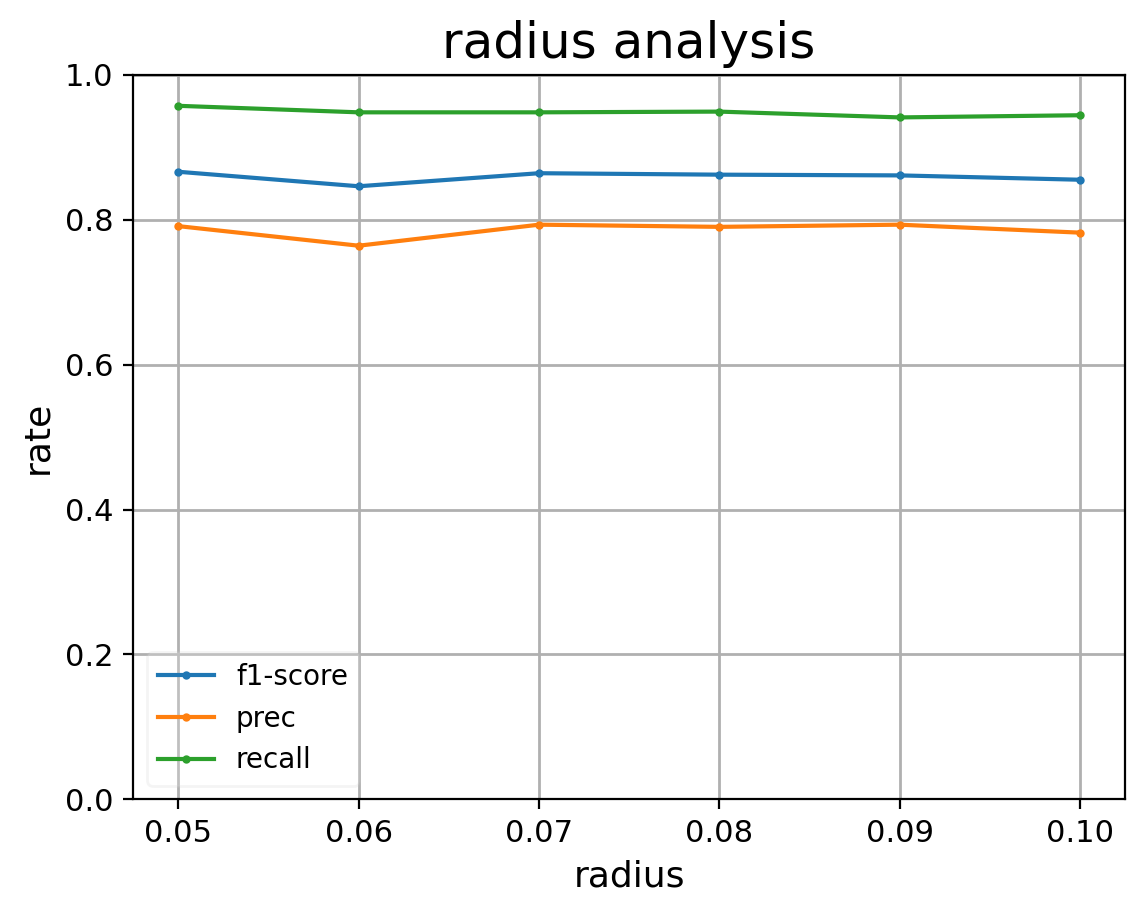

In [189]:
radius = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
f1 = [0.866, 0.846, 0.864, 0.862, 0.861, 0.855]
prec = [0.791, 0.764, 0.793, 0.790, 0.793, 0.782]
recall = [0.957, 0.948, 0.948, 0.949, 0.941, 0.944]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=200)
recalls = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
ax.plot(radius, f1, label='f1-score', linestyle='-', marker='o', markersize='2')
ax.plot(radius, prec, label='prec', linestyle='-', marker='o', markersize='2')
ax.plot(radius, recall, label='recall', linestyle='-', marker='o', markersize='2')
plt.title('radius analysis', fontsize=18)
plt.ylim(0, 1)
ax.set_xlabel('radius', fontsize=13)
ax.set_ylabel('rate', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.grid(True, linestyle='-', linewidth = 1)
legend = ax.legend(loc='best', framealpha=0.2)

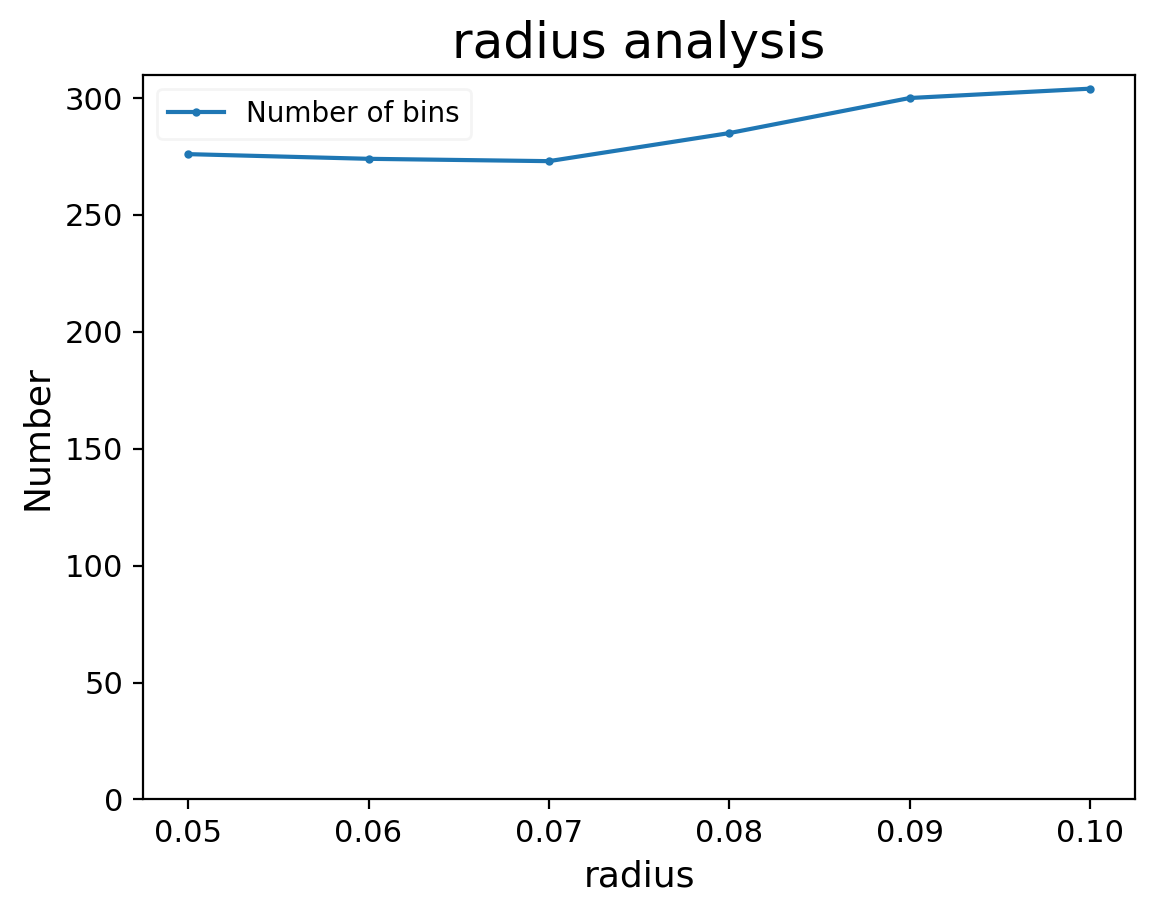

In [16]:
binnums = [276, 274, 273, 285, 300, 304]
radius = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=200)
recalls = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
ax.plot(radius, binnums, label='Number of bins', linestyle='-', marker='o', markersize='2')
plt.title('radius analysis', fontsize=18)
plt.ylim(0, 310)
ax.set_xlabel('radius', fontsize=13)
ax.set_ylabel('Number', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.grid(True, linestyle='', linewidth = 1)
legend = ax.legend(loc='best', framealpha=0.2)

In [24]:
with open('/home/maog/data/metahit/hdbscan_cluster.tsv') as clusters_file:
    DRBin_clusters = DRBin.utils.read_clusters(clusters_file)
    DRBin_bins = DRBin.benchmark.Binning(DRBin_clusters, reference, minsize=200000)

In [25]:
DRBin_bins

Binning(182388/195601 contigs, ReferenceID=0x7fb652b4e310)

In [26]:
print(calcu_recall(DRBin_bins))
print(calcu_prec(DRBin_bins))
print(calcu_f1score(DRBin_bins))

0.7873270171283199
0.36634537359914027
0.5000268924745546


In [196]:
with open('/home/maog/data/airways/result/tnfs_cluster.tsv') as clusters_file:
    tnf_clusters = DRBin.utils.read_clusters(clusters_file)
    tnf_bins = DRBin.benchmark.Binning(DRBin.utils.binsplit(tnf_clusters, 'C'), reference, minsize=200000)
    #tnf_bins = DRBin.benchmark.Binning(tnf_clusters, reference, minsize=200000)
with open('/home/maog/data/airways/result/rpkm_cluster.tsv') as clusters_file:
    rpkm_clusters = DRBin.utils.read_clusters(clusters_file)
    rpkm_bins = DRBin.benchmark.Binning(DRBin.utils.binsplit(rpkm_clusters, 'C'), reference, minsize=200000)
    #rpkm_bins = DRBin.benchmark.Binning(rpkm_clusters, reference, minsize=200000)
with open('/home/maog/data/airways/result/DRBin_cluster.tsv') as clusters_file:
    DRBin_clusters = DRBin.utils.read_clusters(clusters_file)
    #DRBin_bins = DRBin.benchmark.Binning(DRBin.utils.binsplit(DRBin_clusters, '_'), reference, minsize=200000)
    DRBin_bins = DRBin.benchmark.Binning(DRBin_clusters, reference, minsize=200000)
with open('/home/maog/data/airways/result/vmf_cluster.tsv') as clusters_file:
    vmf_clusters = DRBin.utils.read_clusters(clusters_file)
    vmf_bins = DRBin.benchmark.Binning(vmf_clusters, reference, minsize=200000)
    #vmf_bins = DRBin.benchmark.Binning(DRBin.utils.binsplit(vmf_clusters, '_'), reference, minsize=200000)

In [197]:
recalls = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
tnfsbins = []
rpkmbins = []
DRBinbins = []
#vambbins = []
vmfbins = []
j = 0
for i in recalls:
    tnfsbins.append(tnf_bins.counters[j][(i, 0.99)])
    rpkmbins.append(rpkm_bins.counters[j][(i, 0.99)])
    DRBinbins.append(DRBin_bins.counters[j][(i, 0.99)])
    vmfbins.append(vmf_bins.counters[j][(i, 0.99)])

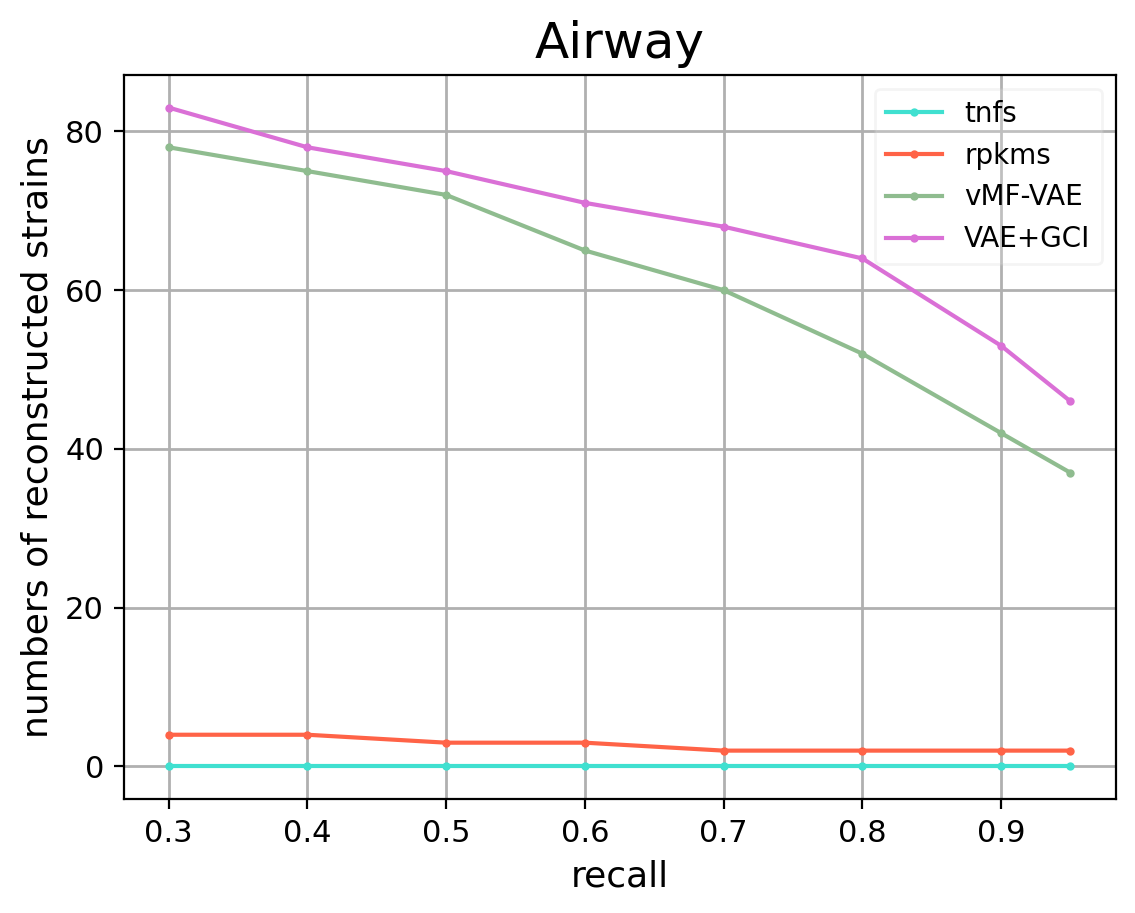

In [198]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=200)
recalls = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
ax.plot(recalls,tnfsbins, label='tnfs', linestyle='-', marker='o',  markersize='2', color='turquoise')
ax.plot(recalls,rpkmbins, label='rpkms', linestyle='-', marker='o', markersize='2', color='tomato')
ax.plot(recalls,DRBinbins, label='vMF-VAE', linestyle='-', marker='o', markersize='2', color='darkseagreen')
#ax.plot(recalls,vambbins, label='vamb', linestyle='-', marker='o', markersize='4')
ax.plot(recalls,vmfbins, label='VAE+GCI', linestyle='-', marker='o', markersize='2', color='orchid')
#ax.plot(recalls, compbins, label='tnfs+rpkms', linestyle='-.', marker='o', markersize='4')
plt.title('Airway', fontsize=18)
ax.set_xlabel('recall', fontsize=13)
ax.set_ylabel('numbers of reconstructed strains', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.grid(True, linestyle='-', linewidth = 1)
legend = ax.legend(loc='best', framealpha=0.2)

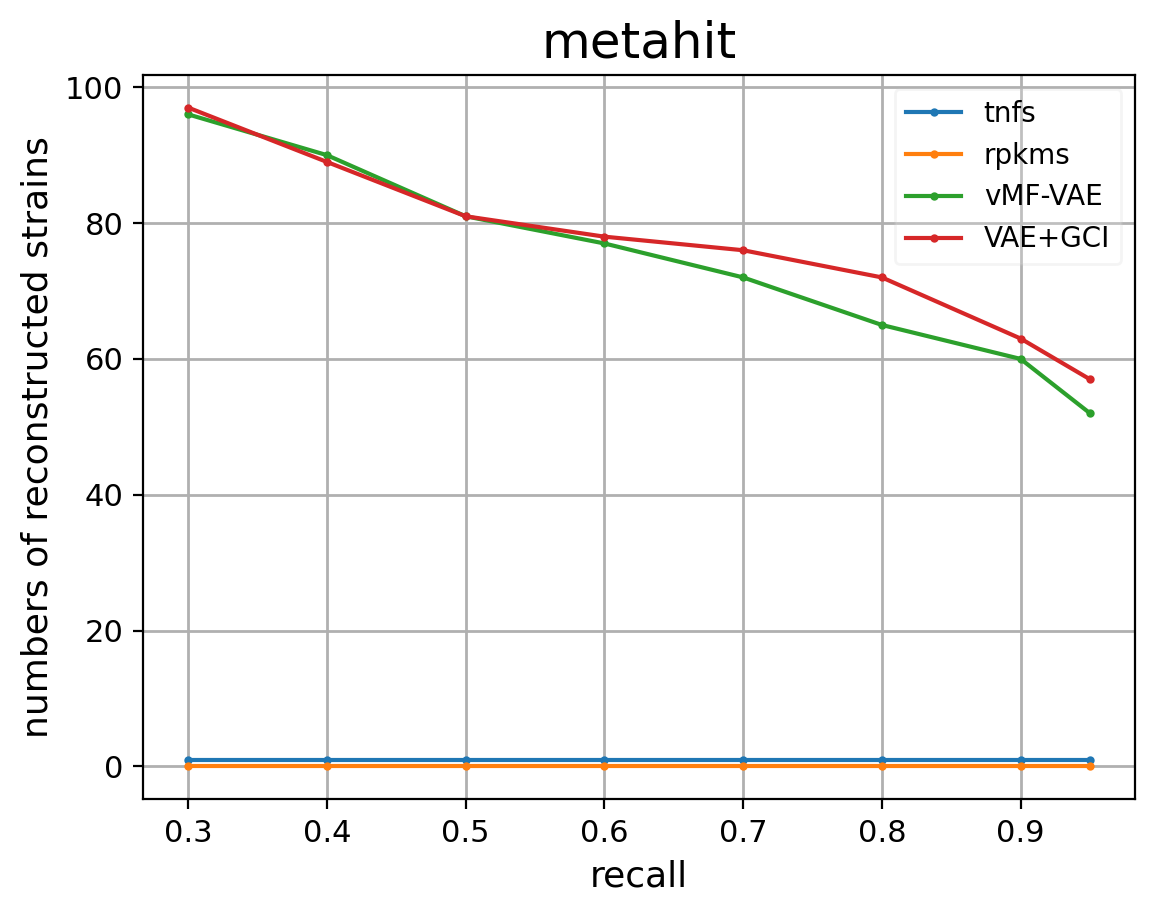

In [188]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=200)
recalls = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
ax.plot(recalls,tnfsbins, label='tnfs', linestyle='-', marker='o',  markersize='2')
ax.plot(recalls,rpkmbins, label='rpkms', linestyle='-', marker='o', markersize='2')
ax.plot(recalls,DRBinbins, label='vMF-VAE', linestyle='-', marker='o', markersize='2')
#ax.plot(recalls,vambbins, label='vamb', linestyle='-', marker='o', markersize='4')
ax.plot(recalls,vmfbins, label='VAE+GCI', linestyle='-', marker='o', markersize='2')
#ax.plot(recalls, compbins, label='tnfs+rpkms', linestyle='-.', marker='o', markersize='4')
plt.title('metahit', fontsize=18)
ax.set_xlabel('recall', fontsize=13)
ax.set_ylabel('numbers of reconstructed strains', fontsize=13)
ax.tick_params(axis='both', labelsize=11)
ax.grid(True, linestyle='-', linewidth = 1)
legend = ax.legend(loc='best', framealpha=0.2)

In [168]:
print(calcu_recall(tnf_bins))
print(calcu_prec(tnf_bins))
print(calcu_f1score(tnf_bins))

0.5242935658379374
1.0
0.6879167866194091


In [187]:
for rank in tnf_bins.summary():
    print('\t'.join(map(str, rank)))

1	1	1	1	1	1	1	1	1
1	1	1	1	1	1	1	1	1
1	1	1	1	1	1	1	1	1
